In [1]:
import pandas as pd
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from numpy import mean
import warnings
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score

# Ignore the warning message
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
def decisionTreeEntropy(y_test, x_test, X_train, y_train, cv, X):
    """
    method fits classifier, carries out cross validation and calculates performance metrics
    optional code to print tree as a figure or text
    """
    clf = DecisionTreeClassifier(criterion="entropy", max_depth=5)
    clf = clf.fit(X_train, y_train)

    # calculate scores with cv
    scores_a = cross_val_score(
        clf, X_train, y_train, scoring="accuracy", cv=cv, n_jobs=-1
    )
    a = mean(scores_a)

    scores_p = cross_val_score(
        clf, X_train, y_train, scoring="precision", cv=cv, n_jobs=-1
    )
    p = mean(scores_p)

    scores_r = cross_val_score(
        clf, X_train, y_train, scoring="recall", cv=cv, n_jobs=-1
    )
    r = mean(scores_r)

    scores_f1 = cross_val_score(clf, X_train, y_train, scoring="f1", cv=cv, n_jobs=-1)
    f1_cv = mean(scores_f1)

    # evaluate the model on the test set
    pred = clf.predict(x_test)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    y_pred = clf.predict_proba(x_test)[:, 1]
    auc = metrics.roc_auc_score(y_test, y_pred)

    # predict and calculate probability
    pred = clf.predict(x_test)
    probs = clf.predict_proba(x_test)

    # code to optional print plot and tree as text
    # feature_cols = list(X.columns)
    # target_cols = ["0", "1"]
    # fig = plt.figure(figsize=(43,30))
    # _ = tree.plot_tree(clf,
    #                 feature_names=feature_cols,
    #                 class_names=target_cols,
    #                 filled=True,
    #                 fontsize=10)

    # nr = str(i)
    # fig.savefig("decistion_tree_"+nr+".png")

    # text_representation = tree.export_text(clf)
    # print(text_representation)

    return accuracy, precision, recall, f1, auc, probs, clf

In [3]:
# specify data frames and set range and feature_cols

metrics_DTE = pd.DataFrame(
    columns=["Sentence", "Accuracy", "Precision", "Recall", "F1", "AUC"]
)
featureImportance = pd.DataFrame(columns=["Sentence", "Feature", "Score"])

n = list(range(2, 61))

feature_cols = [
    "Erstloesung",
    "Schussel",
    "Erfolg",
    "Schwierigkeit",
    "ist_Schulzeit",
    "MehrfachFalsch",
    "vorher_abgebrochen",
    "Fehler",
    "Klassenstufe",
    "Jahredabei",
    "AnzahlAufgaben",
    "Sex__m",
    "Sex__w",
    "Testposition__pruefung",
    "Testposition__training",
    "Testposition__version",
    "Art__GK",
    "Art__GR",
    "Art__GZ",
    "Art__K",
    "Art__LB",
    "UserAttribut",
    "OrderNumber",
    "steps",
]

In [4]:
# loops through all matrices and fits model, saves metrics

for i in n:
    path = "matrices_allsessions/matrix" + str(i) + ".pkl"
    infile = open(path, "rb")
    df = pickle.load(infile)
    infile.close()
    df = df.reset_index()

    X = df[feature_cols]
    y = df.y
    y = y.astype("int")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=1
    )
    k = 5
    cv = KFold(n_splits=k, random_state=None)

    a, p, r, f1, auc, probs, clf = decisionTreeEntropy(
        y_test, X_test, X_train, y_train, cv, X
    )
    metrics_DTE = metrics_DTE.append(
        {
            "Sentence": i,
            "Accuracy": a,
            "Precision": p,
            "Recall": r,
            "F1": f1,
            "AUC": auc,
        },
        ignore_index=True,
    )

    # summarize feature importance
    importance = clf.feature_importances_
    for p, v in enumerate(importance):
        # print('Feature: %0d, Score: %.5f' % (p,v))
        featureImportance = featureImportance.append(
            {"Sentence": i, "Feature": p, "Score": v}, ignore_index=True
        )

metrics_DTE.to_pickle("model_metrics/metrics_DTE.pkl")

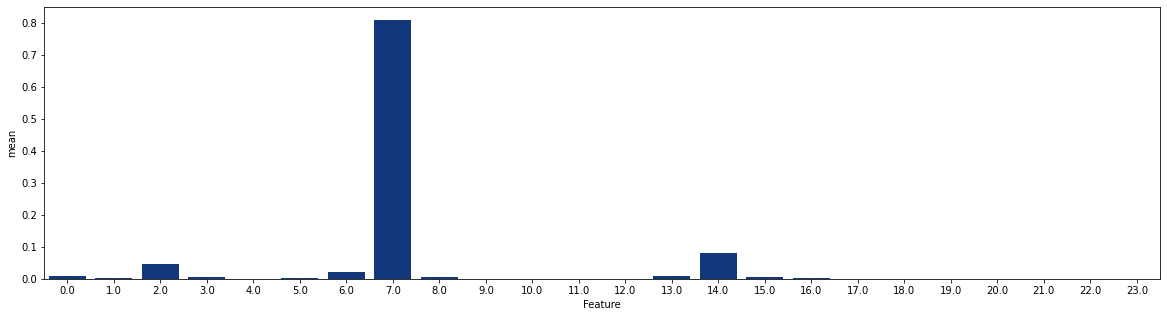

In [5]:
# plot feature importance
featureImportance_grouped = featureImportance.groupby("Feature").agg(
    {"Score": ["mean"]}
)

plt.figure(figsize=(20, 5))
ax = sns.barplot(
    x=featureImportance_grouped.index,
    y=featureImportance_grouped.Score["mean"],
    data=featureImportance_grouped,
    color="#00338d",
)

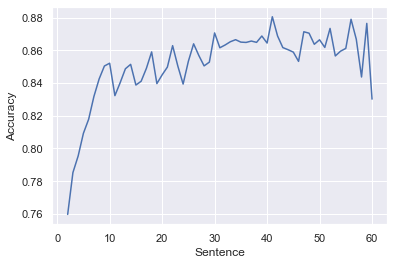

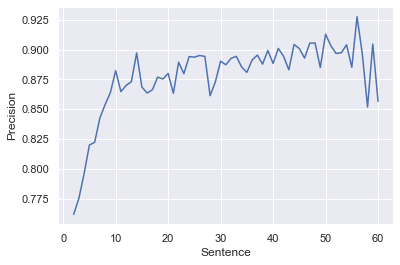

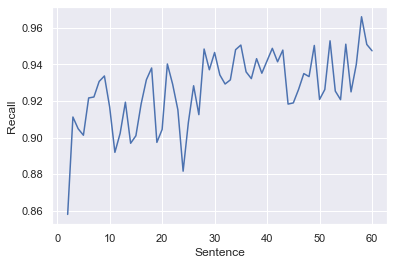

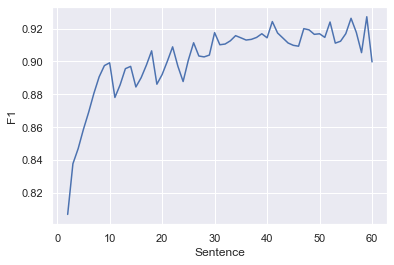

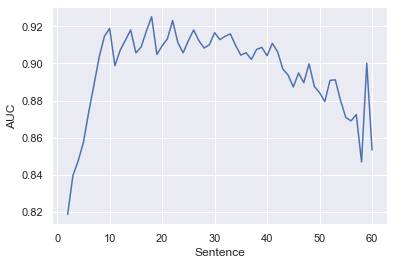

In [6]:
# plot metrics
sns.set_theme()

sns.lineplot(data=metrics_DTE, x="Sentence", y="Accuracy")
plt.show()

sns.lineplot(data=metrics_DTE, x="Sentence", y="Precision")
plt.show()

sns.lineplot(data=metrics_DTE, x="Sentence", y="Recall")
plt.show()

sns.lineplot(data=metrics_DTE, x="Sentence", y="F1")
plt.show()

sns.lineplot(data=metrics_DTE, x="Sentence", y="AUC")
plt.show()

In [7]:
# Code to generate sample probability data
# probability_sample = probs[:, :1].tolist()
# probability_sample = pd.DataFrame(probability_sample)
# probability_sample.to_pickle('DTE55.pkl')